In [17]:
import torch.nn as nn
import torch.nn.functional as F


class ProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_profiles, num_classes,p_y):
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes
        self.p_y = p_y
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_profiles)
        )

        # 使用 register_buffer 保持状态但不被训练
        self.register_buffer("count_z_given_y", torch.zeros(num_profiles, num_classes))  # [T, K]

    def update_profile_counts(self, q_z_given_x, y_true):
        """
        使用 soft assignment 更新 profile 频数表：
        q_z_given_x: [B, T], y_true: [B]
        """
        with torch.no_grad():
            B, T = q_z_given_x.shape
            K = self.num_classes
            one_hot_y = F.one_hot(y_true, K).float()  # [B, K]
            # outer product: for each sample, update count[z, y]
            # Resulting shape: [B, T, K]
            contrib = torch.einsum("bt,bk->btk", q_z_given_x, one_hot_y)
            self.count_z_given_y += contrib.sum(dim=0)  # sum over batch

    def compute_p_z_given_y(self):
        # 避免除以 0：加入平滑
        smoothed = self.count_z_given_y + 1e-3
        return smoothed / smoothed.sum(dim=0, keepdim=True)  # [T, K]



    def forward(self, x):
        # q(Z|X)
        profile_logits = self.encoder(x)
        q_z_given_x = F.softmax(profile_logits, dim=1)  # [B, T]

        # Profile 后验
        p_z_given_y = self.compute_p_z_given_y()  # [T, K]

        # 归一化（每行归一）
        p_z = (p_z_given_y * self.p_y.unsqueeze(0)).sum(dim=1)  # shape [T]

        # 构造完整贝叶斯项：P(Z|Y)*P(Y) / P(Z)
        bayes_matrix = (p_z_given_y * self.p_y.unsqueeze(0)) / (p_z.unsqueeze(1) + 1e-9)  # [T, K]

        # 推理公式：P(Y|X) = sum_z P(Y|Z=z) * P(Z=z|X)
        p_y_given_x = q_z_given_x @ bayes_matrix  # shape [B, K]
        return p_y_given_x, q_z_given_x, p_z_given_y

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

def profile_entropy_regularization(q_z_given_x):
        avg_profile = q_z_given_x.mean(dim=0) + 1e-9
        return -torch.sum(avg_profile * avg_profile.log())

def profile_kl_regularization(q_z_given_x):
    avg_profile = q_z_given_x.mean(dim=0) + 1e-9
    log_avg = avg_profile.log()
    log_uniform = torch.full_like(log_avg, fill_value=torch.log(torch.tensor(1.0 / len(avg_profile))))
    return torch.sum(avg_profile * (log_avg - log_uniform))


import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class GenerativeProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, num_profiles, num_classes):
        """
        input_dim: X 的维度
        num_profiles: 潜在 profile 数 (T)
        num_classes: 类别数 (K)
        """
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes

        # p(Z) 先验 (Categorical 分布)
        self.logits_pz = nn.Parameter(torch.zeros(num_profiles))  # [T]

        # p(X|Z) = Gaussian(mu_z, diag(sigma^2_z))
        self.mu = nn.Parameter(torch.randn(num_profiles, input_dim))  # [T, D]
        self.logvar = nn.Parameter(torch.zeros(num_profiles, input_dim))  # [T, D]

        # p(Y|Z) = Categorical
        self.logits_y_given_z = nn.Parameter(torch.zeros(num_profiles, num_classes))  # [T, K]

    def p_x_given_z(self, x):
        """
        计算 p(x|z) for all z
        x: [B, D], mu/logvar: [T, D]
        return: [B, T]
        """
        B, D = x.shape
        x_expand = x.unsqueeze(1)  # [B, 1, D]
        mu = self.mu.unsqueeze(0)  # [1, T, D]
        logvar = self.logvar.unsqueeze(0)  # [1, T, D]
        var = logvar.exp()

        log_prob = -0.5 * (((x_expand - mu) ** 2) / var + logvar + math.log(2 * math.pi)).sum(dim=2)
        return log_prob.exp()  # [B, T]

    def forward(self, x):
        """
        返回:
          p_y_given_x: [B, K]
          p_z_given_x: [B, T]
        """
        B = x.size(0)

        # p(z) = softmax(logits_pz)
        p_z = F.softmax(self.logits_pz, dim=0)  # [T]

        # p(x|z)
        p_x_given_z = self.p_x_given_z(x)  # [B, T]

        # p(z|x) ∝ p(x|z) p(z)
        log_posterior = torch.log(p_x_given_z + 1e-9) + torch.log(p_z.unsqueeze(0) + 1e-9)  # [B, T]
        p_z_given_x = F.softmax(log_posterior, dim=1)  # [B, T]

        # p(y|z)
        p_y_given_z = F.softmax(self.logits_y_given_z, dim=1)  # [T, K]

        # p(y|x) = ∑_z p(y|z) p(z|x)
        p_y_given_x = p_z_given_x @ p_y_given_z  # [B, K]

        return p_y_given_x, p_z_given_x, p_y_given_z

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

    def generate(self, num_samples=10):
        """
        生成样本 (x, y)
        """
        with torch.no_grad():
            # 1. 采样 z ~ p(z)
            p_z = F.softmax(self.logits_pz, dim=0)
            z = torch.multinomial(p_z, num_samples=num_samples, replacement=True)  # [N]

            # 2. 采样 x ~ p(x|z)
            mu = self.mu[z]       # [N, D]
            logvar = self.logvar[z]
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            x = mu + eps * std

            # 3. 采样 y ~ p(y|z)
            p_y_given_z = F.softmax(self.logits_y_given_z[z], dim=1)  # [N, K]
            y = torch.multinomial(p_y_given_z, num_samples=1).squeeze(1)  # [N]

            return x, y, z


In [18]:
from sklearn.datasets import make_circles, make_moons
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from dbc.utils import compute_prior

# 生成数据
# X, y = datasets.make_blobs(
#     n_samples=[125 * 10, 125 * 4],
#     n_features=2,
#     centers=[(9.5, 10), (10, 9.4)],
#     cluster_std=[[0.6, 0.6], [0.35, 0.3]],
#     shuffle=True
# )
# X, y = make_circles(n_samples=2000, noise=0.3, factor=0.3)
X, y = make_moons(n_samples=2000, noise=0.3)
# 归一化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

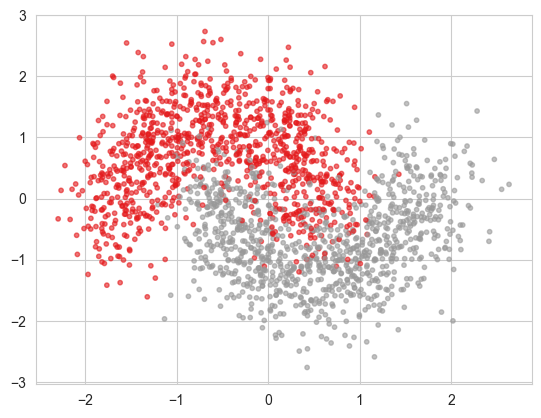

In [19]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.6, s=10)

In [20]:

from dbc.main import KmeansDiscreteBayesianClassifier, DecisionTreeDiscreteBayesianClassifier
from dbc.utils import compute_conditional_risk
from sklearn.metrics import accuracy_score

DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=8)
DBC_kmeans.fit(X_train, y_train)
y_pred = DBC_kmeans.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_val, y_pred)}')

Kmeans Class condition risk: 
[0.13225806 0.1       ]

Kmeans Acc: 
0.8833333333333333


In [21]:
DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
DBC_DT.fit(X_train, y_train)
y_pred = DBC_DT.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'DT Class condition risk: \n{conditional_risk[0]}')
print(f'\nDT Acc: \n{accuracy_score(y_val, y_pred)}')

DT Class condition risk: 
[0.1483871  0.09655172]

DT Acc: 
0.8766666666666667


In [22]:
p_y = torch.tensor(compute_prior(y_train, 2), dtype=torch.float32)

# 转成 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

Epoch   1: Train Loss=7.6238, Val Loss=3.4659 | Train Acc=0.5071 | Val Acc=0.4833
Epoch   2: Train Loss=7.6109, Val Loss=3.4513 | Train Acc=0.5071 | Val Acc=0.4917
Epoch   3: Train Loss=7.5211, Val Loss=3.3568 | Train Acc=0.7429 | Val Acc=0.8400
Epoch   4: Train Loss=7.1783, Val Loss=3.1054 | Train Acc=0.8557 | Val Acc=0.8433
Epoch   5: Train Loss=6.7084, Val Loss=2.9371 | Train Acc=0.8607 | Val Acc=0.8517
Epoch   6: Train Loss=6.3766, Val Loss=2.8217 | Train Acc=0.8700 | Val Acc=0.8567
Epoch   7: Train Loss=6.1471, Val Loss=2.7312 | Train Acc=0.8800 | Val Acc=0.8567
Epoch   8: Train Loss=5.9581, Val Loss=2.6653 | Train Acc=0.8893 | Val Acc=0.8667
Epoch   9: Train Loss=5.8113, Val Loss=2.6087 | Train Acc=0.8914 | Val Acc=0.8767
Epoch  10: Train Loss=5.6811, Val Loss=2.5467 | Train Acc=0.9021 | Val Acc=0.8800
Epoch  11: Train Loss=5.5664, Val Loss=2.5061 | Train Acc=0.9100 | Val Acc=0.8917
Epoch  12: Train Loss=5.4664, Val Loss=2.4583 | Train Acc=0.9179 | Val Acc=0.8933
Epoch  13: Train

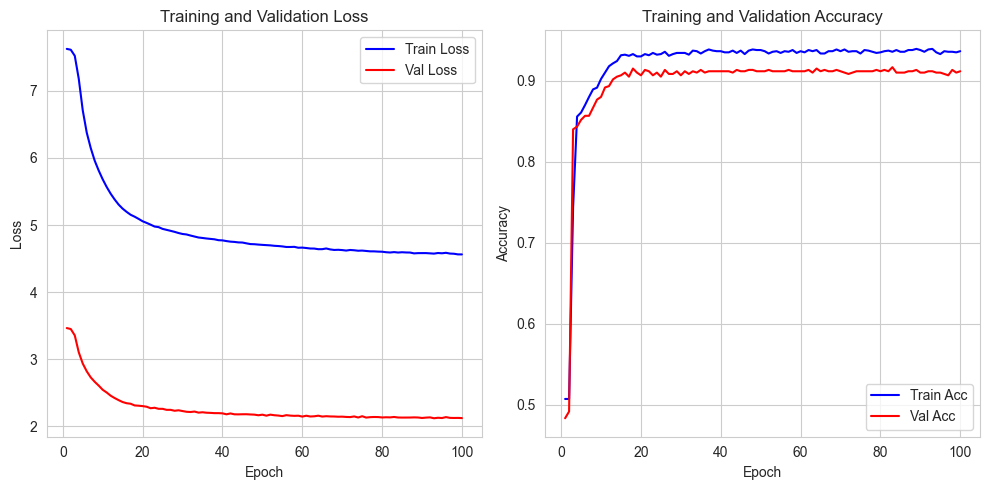

In [23]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


input_dim = 2  # 特征维度
hidden_dim = 64
num_profiles = 6
num_classes = 2

model = ProfileBayesClassifier(input_dim, hidden_dim, num_profiles, num_classes,p_y)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


num_epochs = 100
train_losses = []
val_losses = []  # 添加验证损失列表
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, q_z_given_x, _ = model(X_batch)
        model.update_profile_counts(q_z_given_x, y_batch)
        loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
        loss.backward()
        optimizer.step()
        train_total_loss += loss.item()

        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x = model.predict(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            correct += (torch.argmax(p_y_given_x, dim=1) == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    acc = correct / total
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1:3d}: Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | Train Acc={train_accuracies[-1]:.4f} | Val Acc={acc:.4f}")

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/jj/gtt8rdq925x6cg1h89ndvd8w0000gn/T/ipykernel_96731/607068827.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),  # 可以调整步长来控制分辨率
/var/folders/jj/gtt8rdq925x6cg1h89ndvd8w0000gn/T/ipykernel_96731/607068827.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(y_min, y_max, 0.02))


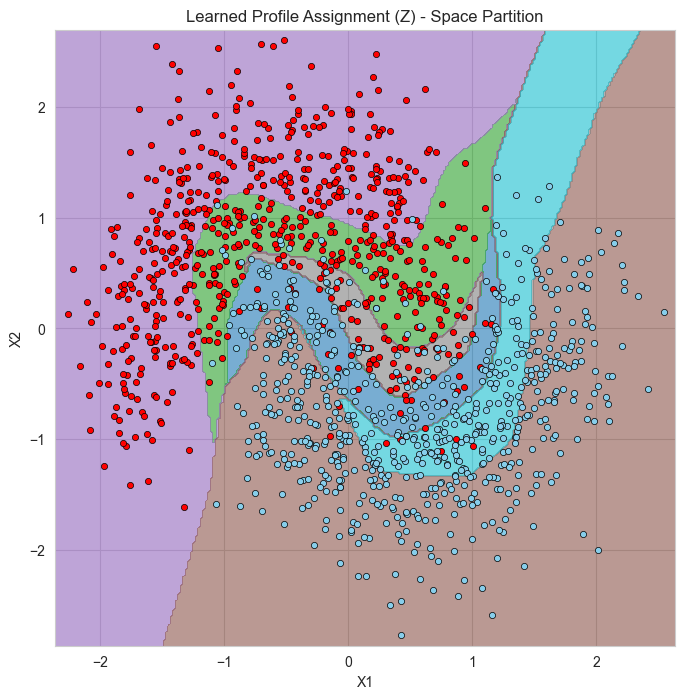

In [24]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # 创建网格
    padding=0.1
    x_min, x_max = X_train[:, 0].min() - padding, X_train[:, 0].max() + padding
    y_min, y_max = X_train[:, 1].min() - padding, X_train[:, 1].max() + padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),  # 可以调整步长来控制分辨率
                         np.arange(y_min, y_max, 0.02))

    # 将网格点转换为张量
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # 预测网格点的Profile Assignment
    _, q_z_given_x_grid, _ = model(grid_points)
    Z_grid_1 = torch.argmax(q_z_given_x_grid, dim=1)
    Z_grid_1 = Z_grid_1.reshape(xx.shape)

    # 预测训练数据的Profile Assignment用于对比
    _, q_z_given_x, _ = model(X_train)
    Z_val_1 = torch.argmax(q_z_given_x, dim=1)

plt.figure(figsize=(8, 8))
# 使用contourf绘制颜色区域
plt.contourf(xx, yy, Z_grid_1, levels=np.arange(model.num_profiles + 1) - 0.5,
             cmap="tab10", alpha=0.6)
# 在上面叠加训练数据点
# plt.scatter(X_train[:, 0], X_train[:, 1], c=Z_val_1, cmap="tab10",
#            edgecolors='black', linewidth=0.5, s=20)
# 在上面叠加训练数据点
class_0_mask = (y_train == 0)
class_1_mask = (y_train == 1)
plt.scatter(X_train[class_0_mask, 0], X_train[class_0_mask, 1],
           c='red', edgecolors='black', linewidth=0.5, s=20, label='Class 0')
plt.scatter(X_train[class_1_mask, 0], X_train[class_1_mask, 1],
           c='skyblue', edgecolors='black', linewidth=0.5, s=20, label='Class 1')
plt.title("Learned Profile Assignment (Z) - Space Partition")
plt.xlabel("X1")
plt.ylabel("X2")
# plt.colorbar(label='Profile')
plt.show()

Epoch   1: Train Loss=7.6148, Val Loss=3.4566 | Train Acc=0.7007 | Val Acc=0.7250
Epoch   2: Train Loss=7.5934, Val Loss=3.4470 | Train Acc=0.7214 | Val Acc=0.7233
Epoch   3: Train Loss=7.5705, Val Loss=3.4370 | Train Acc=0.7271 | Val Acc=0.7250
Epoch   4: Train Loss=7.5471, Val Loss=3.4264 | Train Acc=0.7300 | Val Acc=0.7317
Epoch   5: Train Loss=7.5214, Val Loss=3.4154 | Train Acc=0.7321 | Val Acc=0.7333
Epoch   6: Train Loss=7.4953, Val Loss=3.4037 | Train Acc=0.7371 | Val Acc=0.7400
Epoch   7: Train Loss=7.4674, Val Loss=3.3916 | Train Acc=0.7436 | Val Acc=0.7400
Epoch   8: Train Loss=7.4388, Val Loss=3.3790 | Train Acc=0.7479 | Val Acc=0.7450
Epoch   9: Train Loss=7.4091, Val Loss=3.3656 | Train Acc=0.7529 | Val Acc=0.7517
Epoch  10: Train Loss=7.3769, Val Loss=3.3521 | Train Acc=0.7593 | Val Acc=0.7583
Epoch  11: Train Loss=7.3450, Val Loss=3.3379 | Train Acc=0.7636 | Val Acc=0.7650
Epoch  12: Train Loss=7.3118, Val Loss=3.3233 | Train Acc=0.7721 | Val Acc=0.7667
Epoch  13: Train

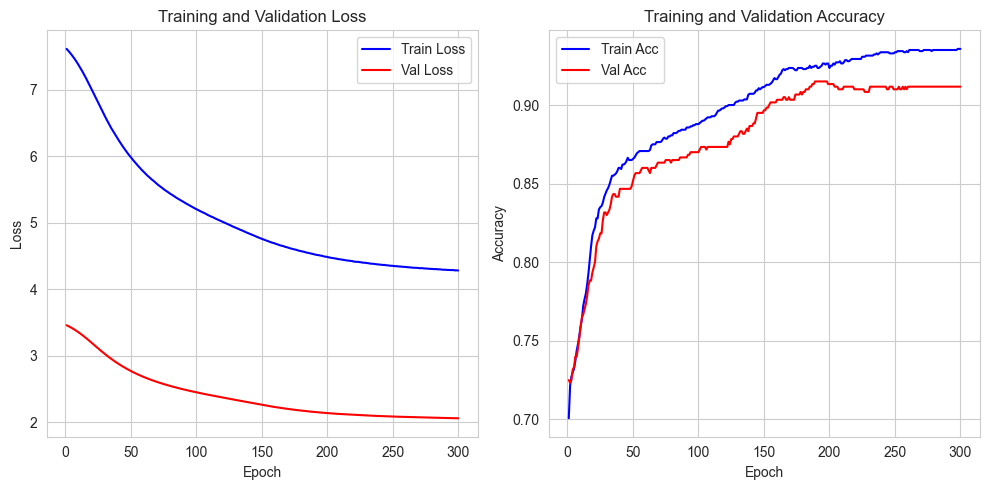

In [25]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

input_dim = 2  # 特征维度
num_profiles = 6
num_classes = 2

# 用生成式版本
model = GenerativeProfileBayesClassifier(input_dim, num_profiles, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 300
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, p_z_given_x, p_y_given_z = model(X_batch)

        loss = criterion(p_y_given_x, y_batch)  # 分类损失
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x, _, _ = model(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            preds = torch.argmax(p_y_given_x, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1:3d}: "
          f"Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | "
          f"Train Acc={train_accuracies[-1]:.4f} | Val Acc={val_accuracies[-1]:.4f}")

# 绘制训练和验证曲线
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


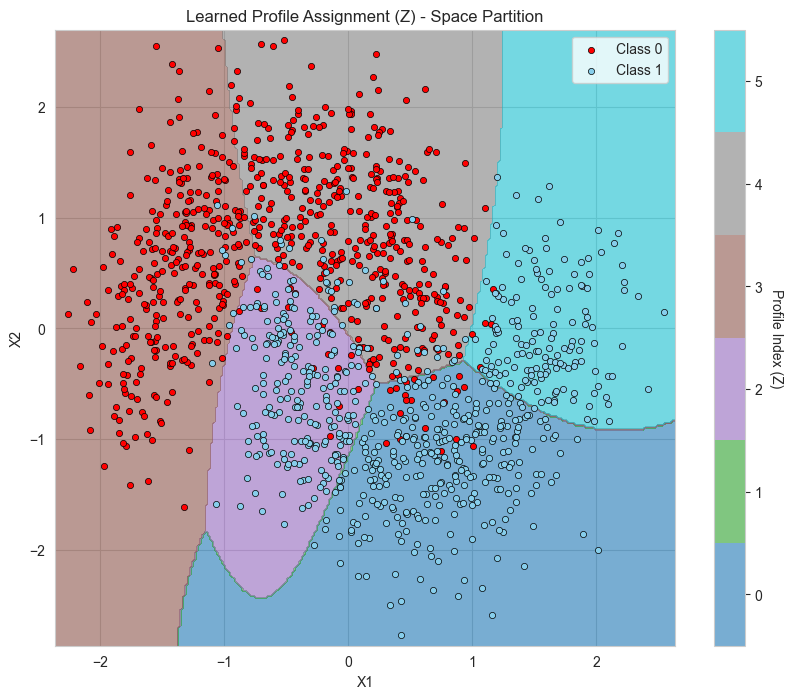

In [29]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # 创建网格
    padding=0.1
    x_min, x_max = X_train[:, 0].detach().numpy().min() - padding, X_train[:, 0].detach().numpy().max() + padding
    y_min, y_max = X_train[:, 1].detach().numpy().min() - padding, X_train[:, 1].detach().numpy().max() + padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # 将网格点转换为张量
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # 预测网格点的Profile Assignment
    _, q_z_given_x_grid, _ = model(grid_points)
    Z_grid_2 = torch.argmax(q_z_given_x_grid, dim=1)
    Z_grid_2 = Z_grid_2.detach().numpy().reshape(xx.shape)

    # 预测训练数据的Profile Assignment用于对比
    _, q_z_given_x, _ = model(X_train)
    Z_val_2 = torch.argmax(q_z_given_x, dim=1)

plt.figure(figsize=(10, 8))

# 使用contourf绘制颜色区域
contour = plt.contourf(xx, yy, Z_grid_2, levels=np.arange(model.num_profiles + 1) - 0.5,
                       cmap="tab10", alpha=0.6)

# 添加颜色条显示 profile 编号
cbar = plt.colorbar(contour, ticks=np.arange(model.num_profiles))
cbar.set_label('Profile Index (Z)', rotation=270, labelpad=15)

# 在上面叠加训练数据点
class_0_mask = (y_train == 0)
class_1_mask = (y_train == 1)
plt.scatter(X_train[class_0_mask, 0], X_train[class_0_mask, 1],
           c='red', edgecolors='black', linewidth=0.5, s=20, label='Class 0')
plt.scatter(X_train[class_1_mask, 0], X_train[class_1_mask, 1],
           c='skyblue', edgecolors='black', linewidth=0.5, s=20, label='Class 1')

plt.title("Learned Profile Assignment (Z) - Space Partition")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

In [30]:
q_z_given_x_grid

tensor([[8.8552e-04, 5.1024e-05, 1.2166e-04, 9.9808e-01, 3.0239e-04, 5.5484e-04],
        [8.7206e-04, 4.8026e-05, 1.1451e-04, 9.9816e-01, 2.8462e-04, 5.2224e-04],
        [8.6672e-04, 4.5339e-05, 1.0810e-04, 9.9822e-01, 2.6870e-04, 4.9303e-04],
        ...,
        [2.6168e-07, 1.9642e-08, 4.6832e-08, 1.6510e-07, 1.2286e-07, 1.0000e+00],
        [2.9393e-07, 2.2063e-08, 5.2605e-08, 1.8545e-07, 1.3578e-07, 1.0000e+00],
        [3.3149e-07, 2.4882e-08, 5.9327e-08, 2.0915e-07, 1.5138e-07, 1.0000e+00]])

In [27]:
F.softmax(model.logits_pz,dim=0)

tensor([0.3179, 0.0239, 0.0569, 0.2005, 0.1414, 0.2594],
       grad_fn=<SoftmaxBackward0>)

TypeError: Shapes of x (769, 741) and z (279, 251) do not match

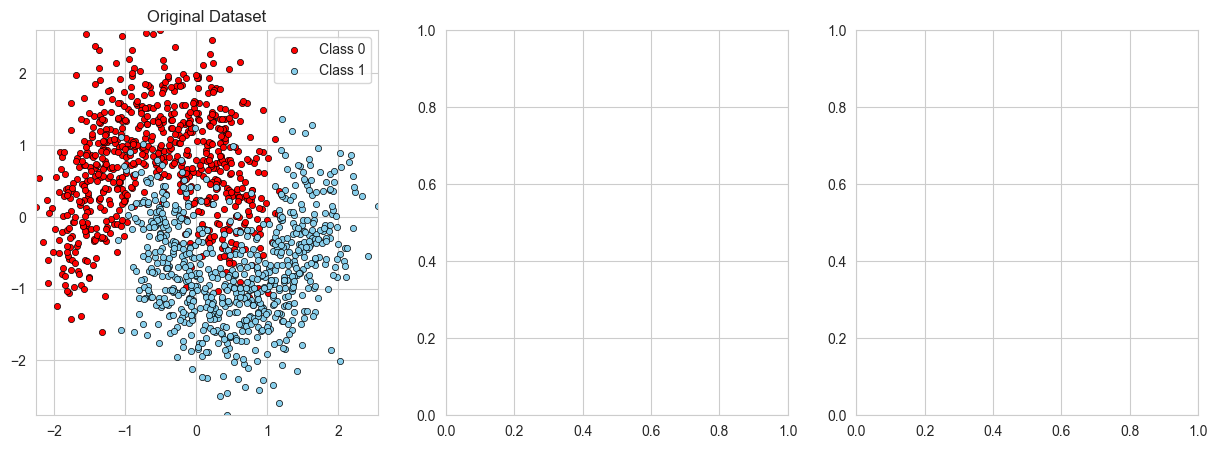

In [28]:
# 首先计算所有数据的范围
x_min = X_train[:, 0].min()
x_max = X_train[:, 0].max()
y_min = X_train[:, 1].min()
y_max = X_train[:, 1].max()

plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
class_0_mask = (y_train == 0)
class_1_mask = (y_train == 1)

# 分别绘制每个类别
plt.scatter(X_train[class_0_mask, 0], X_train[class_0_mask, 1],
           c='red', edgecolors='black', linewidth=0.5, s=20, label='Class 0')
plt.scatter(X_train[class_1_mask, 0], X_train[class_1_mask, 1],
           c='skyblue', edgecolors='black', linewidth=0.5, s=20, label='Class 1')

plt.title("Original Dataset")
plt.xlim(x_min, x_max)  # 设置x轴范围
plt.ylim(y_min, y_max)  # 设置y轴范围
plt.legend()

plt.subplot(1,3,2)
plt.contourf(xx, yy, Z_grid_1, levels=np.arange(6 + 1) - 0.5,
             cmap="tab10", alpha=0.2)
plt.scatter(X_train[:,0],X_train[:,1],c=Z_val_1,cmap="tab10",edgecolors='black',linewidth=0.5,s=20)
plt.title("Discriminative DBC")
plt.xlim(x_min, x_max)  # 设置x轴范围
plt.ylim(y_min, y_max)  # 设置y轴范围

plt.subplot(1,3,3)
plt.contourf(xx, yy, Z_grid_2, levels=np.arange(6 + 1) - 0.5,
             cmap="tab10", alpha=0.2)
plt.scatter(X_train[:,0],X_train[:,1],c=Z_val_2,cmap="tab10",edgecolors='black',linewidth=0.5,s=20)
plt.title("Generative DBC")
plt.xlim(x_min, x_max)  # 设置x轴范围
plt.ylim(y_min, y_max)  # 设置y轴范围

plt.savefig('example3.pdf', dpi=300, bbox_inches='tight')


In [13]:

# moons
# KMeans:
# avg acc: 0.8825
# std: 0.0200
#
# Decision Tree:
# avg acc: 0.8496
# std: 0.1076
#
# Cmeans:
# avg acc: 0.8842
# std: 0.0189
#
# Discriminative Neural Network:
# avg acc: 0.9114
# std: 0.0113
#
# Generative Neural Network:
# avg acc: 0.9113
# std: 0.0113
#
#
# blobs
# KMeans:
# avg acc: 0.8044
# std: 0.0301
#
# Decision Tree:
# avg acc: 0.7812
# std: 0.1049
#
# Cmeans:
# avg acc: 0.8102
# std: 0.0253
#
# Discriminative Neural Network:
# avg acc: 0.8266
# std: 0.0226
#
# Generative Neural Network:
# avg acc: 0.8309
# std: 0.0234

# circles
# KMeans:
# avg acc: 0.6710
# std: 0.0319
#
# Decision Tree:
# avg acc: 0.6928
# std: 0.0755
#
# Cmeans:
# avg acc: 0.7107
# std: 0.0306
#
# Discriminative Neural Network:
# avg acc: 0.7829
# std: 0.0189
#
# Generative Neural Network:
# avg acc: 0.7863
# std: 0.0171

使用设备: cpu


  0%|          | 0/100 [00:00<?, ?it/s]Error processing line 1 of /opt/miniconda3/envs/RML/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/opt/miniconda3/envs/RML/lib/python3.11/site.py", line 195, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


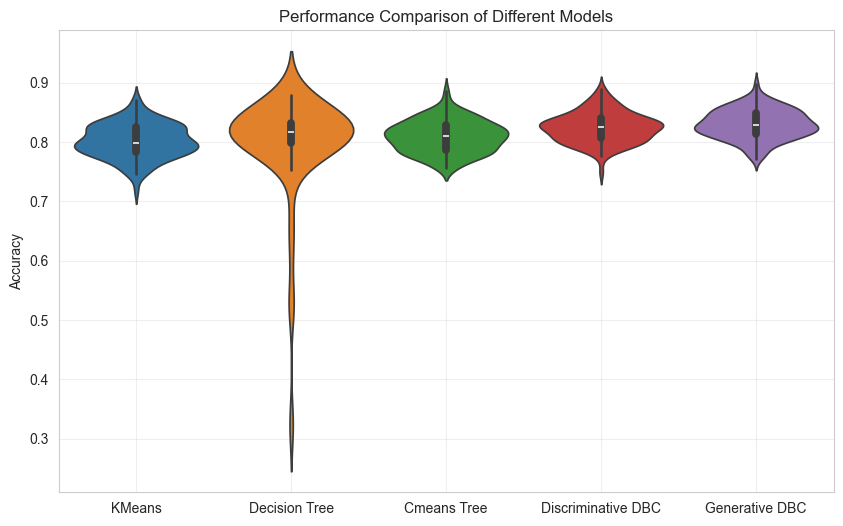

模型性能统计信息：

KMeans:
avg acc: 0.8019
std: 0.0285

Decision Tree:
avg acc: 0.7953
std: 0.0931

Cmeans:
avg acc: 0.8093
std: 0.0267

Discriminative Neural Network:
avg acc: 0.8247
std: 0.0252

Generative Neural Network:
avg acc: 0.8303
std: 0.0244


In [14]:
# 执行100次实验并绘制性能比较小提琴图
from dbc.main import CmeansDiscreteBayesianClassifier
import numpy as np
import seaborn as sns
from tqdm import tqdm

# 检查GPU可用性并设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 存储100次实验的结果
kmeans_accs = []
dt_accs = []
cmeans_accs = []
dis_nn_accs = []
ger_nn_accs = []

# 执行100次实验
for i in tqdm(range(100)):
    # 重新生成数据
    X, y = datasets.make_blobs(
        n_samples=[125 * 5, 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True
    )
    # X, y = make_circles(n_samples=2000, noise=0.3, factor=0.5)
    # X, y = make_moons(n_samples=2000, noise=0.3)

    # 归一化
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 分割数据
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

    # KMeans实验
    DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=8)
    DBC_kmeans.fit(X_train, y_train)
    y_pred_kmeans = DBC_kmeans.predict(X_val)
    kmeans_acc = accuracy_score(y_val, y_pred_kmeans)
    kmeans_accs.append(kmeans_acc)
    # CMeans实验
    SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=8,fuzzifier=1.3,use_kmeans=True)
    SPDBC.fit(X_train, y_train)
    y_pred_cmeans = SPDBC.predict(X_val)
    cmeans_acc = accuracy_score(y_val, y_pred_cmeans)
    cmeans_accs.append(cmeans_acc)

    # 决策树实验
    DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
    DBC_DT.fit(X_train, y_train)
    y_pred_dt = DBC_DT.predict(X_val)
    dt_acc = accuracy_score(y_val, y_pred_dt)
    dt_accs.append(dt_acc)

    # 神经网络实验 - 修改部分
    p_y = torch.tensor(compute_prior(y_train, 2), dtype=torch.float32).to(device)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    # 创建数据加载器
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # 初始化模型并移到GPU
    model = ProfileBayesClassifier(input_dim, 64, num_profiles, num_classes, p_y).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 训练模型
    for epoch in range(100):
        model.train()
        for X_batch, y_batch in train_loader:
            # 数据已经在创建时移到了GPU，这里不需要再移动
            optimizer.zero_grad()
            p_y_given_x, q_z_given_x, _ = model(X_batch)
            model.update_profile_counts(q_z_given_x, y_batch)
            loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
            loss.backward()
            optimizer.step()

    # 评估神经网络模型
    model.eval()
    with torch.no_grad():
        y_pred_dis_nn = torch.argmax(model.predict(X_val_tensor), dim=1)
        # 将结果移回CPU进行准确率计算
        dis_nn_acc = accuracy_score(y_val_tensor.cpu(), y_pred_dis_nn.cpu())
        dis_nn_accs.append(dis_nn_acc)

    # 生成式模型
    model = GenerativeProfileBayesClassifier(input_dim, num_profiles, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 训练模型
    for epoch in range(300):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            p_y_given_x, p_z_given_x, p_y_given_z = model(X_batch)

            loss = criterion(p_y_given_x, y_batch)  # 分类损失
            loss.backward()
            optimizer.step()

    # 评估神经网络模型
    model.eval()
    with torch.no_grad():
        y_pred_ger_nn = torch.argmax(model.predict(X_val_tensor), dim=1)
        # 将结果移回CPU进行准确率计算
        ger_nn_acc = accuracy_score(y_val_tensor.cpu(), y_pred_ger_nn.cpu())
        ger_nn_accs.append(ger_nn_acc)

# 创建绘图数据
plot_data = {
    'KMeans': kmeans_accs,
    'Decision Tree': dt_accs,
    'Cmeans Tree': cmeans_accs,
    'Discriminative DBC': dis_nn_accs,
    'Generative DBC': ger_nn_accs,  # 修正这里的错误
}

# 设置绘图样式
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data)
plt.title('Performance Comparison of Different Models')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

# 打印统计信息
print("模型性能统计信息：")
print("\nKMeans:")
print(f"avg acc: {np.mean(kmeans_accs):.4f}")
print(f"std: {np.std(kmeans_accs):.4f}")

print("\nDecision Tree:")
print(f"avg acc: {np.mean(dt_accs):.4f}")
print(f"std: {np.std(dt_accs):.4f}")

print("\nCmeans:")
print(f"avg acc: {np.mean(cmeans_accs):.4f}")
print(f"std: {np.std(cmeans_accs):.4f}")

print("\nDiscriminative Neural Network:")
print(f"avg acc: {np.mean(dis_nn_accs):.4f}")
print(f"std: {np.std(dis_nn_accs):.4f}")

print("\nGenerative Neural Network:")
print(f"avg acc: {np.mean(ger_nn_accs):.4f}")
print(f"std: {np.std(ger_nn_accs):.4f}")